*Made by Artem Vazhentsev (AIRI)*

*Partially based on: https://github.com/xcmyz/FastSpeech*

## Problem

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

We'll deal with a simplified dataset. One dataset sample is an utterance described by

* Input:
  * *raw text*;
  * *phoneme alignment*, i.e. start time and duration for each phoneme.
* Target:
  * [mel spectrogram](https://pytorch.org/audio/stable/transforms.html#melspectrogram) (frequency representation of audio) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

Raw waveform audio transforms into **mel spectrogram**:

  1. We took samples of air pressure over time to digitally represent an audio signal
  2. We mapped the audio signal from the time domain to the frequency domain using the *fast Fourier transform*, and we performed this on overlapping windowed segments of the audio signal.
  3. We converted the y-axis (frequency) to a log scale and the color dimension (amplitude) to decibels to form the spectrogram.
  4. We mapped the y-axis (frequency) onto the mel scale to form the mel spectrogram.

  <img src="https://drive.google.com/uc?export=view&id=1yfbI9GyU8JS0qz54Q7N8f8gh4eMPYZr_" width="400">

You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies

From the mel spectrogram, we generate audio using the pretrained WaveGlow model.

WaveGlow is a generative model that generates audio by sampling from a distribution. To use a neural network as a generative model, we take samples from a simple distribution, in our
case, a zero mean spherical Gaussian with the same number
of dimensions as our desired output, and put those samples
through a series of layers that transforms the simple distribution to one which has the desired distribution

<img src="https://drive.google.com/uc?export=view&id=1-ZekH8AXXwINd65Ilrq5TuDSOgoOr4WT" width="400">

source: https://arxiv.org/pdf/1811.00002v1.pdf

In [ ]:
!pip install numpy scipy librosa unidecode inflect librosa datasets transformers torchaudio
!apt-get update
!apt-get install -y libsndfile1

In [ ]:
# download alignments
!gdown 1p6wimyRl7ErZjR5F_day9APHUutTMy-6
!unzip alignments

In [ ]:
# download trained model dict
!gdown 1rOEP8LKWeuhWrEgzUv6aKVRK7j4-UNrl

In [4]:
import os
import time
import math
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Audio
from collections import OrderedDict


import torch
import torchaudio
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#compression for normalizing spectrogram
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)

In [6]:
#load LJ speech dataset
#https://keithito.com/LJ-Speech-Dataset/
dataset = load_dataset("lj_speech")
sample_rate = dataset['train'].features["audio"].sampling_rate
sample_audio = dataset['train'][3]["audio"]['array']

Generating train split:   0%|          | 0/13100 [00:00<?, ? examples/s]

Dataset lj_speech downloaded and prepared to /root/.cache/huggingface/datasets/lj_speech/main/1.1.0/6e03b5308ab68705d902e2bbeaff59feb283307770fafb8d6704e604b6d179aa. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
mel_specgram = librosa.feature.melspectrogram(y=sample_audio, sr=sample_rate, n_mels=80, hop_length=256, n_fft=1024)
mel_specgram = dynamic_range_compression(torch.Tensor(mel_specgram))

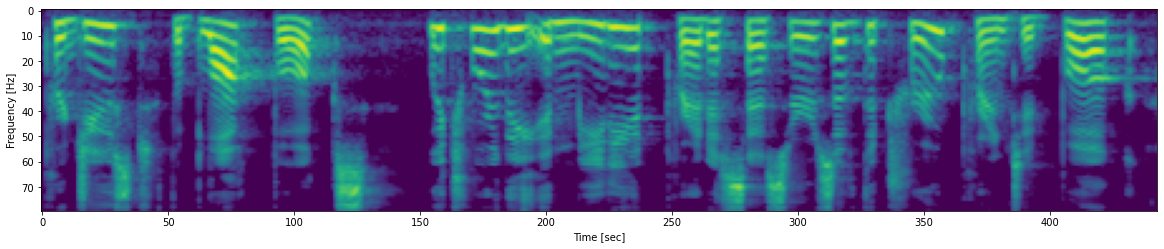

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(mel_specgram.numpy())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [9]:
Audio(sample_audio, rate=sample_rate)

## FastSpeech Architecture

<img src="https://drive.google.com/uc?export=view&id=1BQxPd20Zq-okqmLZk6jIILzjR1-P6PCj" width="700">

source: https://arxiv.org/pdf/1905.09263.pdf

### Basic Functions

In [10]:
#define functions for padding tensors and arrays
def pad_1D_tensor(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = F.pad(x, (0, length - x.shape[0]))
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = torch.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded


def pad_1D(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = np.pad(x, (0, length - x.shape[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = np.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded

def pad_2D_tensor(inputs, maxlen=None):

    def pad(x, max_len):
        if x.size(1) > max_len:
            raise ValueError("not max_len")

        s = x.size(0)
        x_padded = F.pad(x, (0, max_len-x.size(1), 0, 0))
        return x_padded[:s, :]

    if maxlen:
        output = torch.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(x.size(1) for x in inputs)
        output = torch.stack([pad(x, max_len) for x in inputs])

    return output

def pad_2D(inputs, maxlen=None):

    def pad(x, max_len):
        PAD = 0
        if np.shape(x)[0] > max_len:
            raise ValueError("not max_len")

        s = np.shape(x)[1]
        x_padded = np.pad(x, (0, max_len - np.shape(x)[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded[:, :s]

    if maxlen:
        output = np.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(np.shape(x)[0] for x in inputs)
        output = np.stack([pad(x, max_len) for x in inputs])

    return output

In [11]:
#functions for loading and preprocessing data 

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

def get_data(dataset, alignment_path="./alignments"):
    buffer = list()

    start = time.perf_counter()
    num_samples = dataset['train'].num_rows

    for i in tqdm(range(num_samples)):

        waveform_audio = dataset['train'][i]['audio']['array']
        mel_specgram = librosa.feature.melspectrogram(y=waveform_audio, sr=sample_rate, n_mels=80, hop_length=256, n_fft=1024)
        mel_specgram = dynamic_range_compression(torch.Tensor(mel_specgram))

        duration = np.load(os.path.join(
            alignment_path, str(i)+".npy"))
        
        text = dataset['train'][i]['normalized_text']
        sequences, lengths = utils.prepare_input_sequence([text])
        character = sequences[0].cpu().detach().numpy()

        character = torch.from_numpy(character)
        duration = torch.from_numpy(duration)

        min_len = min(len(character), len(duration))
        buffer.append({"text": character[:min_len], "duration": duration[:min_len],
                       "mel_target": mel_specgram})

    end = time.perf_counter()
    print("cost {:.2f}s to load all data into buffer.".format(end-start))

    return buffer

def reprocess_tensor(batch, cut_list):
    texts = [batch[ind]["text"] for ind in cut_list]
    mel_targets = [batch[ind]["mel_target"] for ind in cut_list]
    durations = [batch[ind]["duration"] for ind in cut_list]

    length_text = np.array([])
    for text in texts:
        length_text = np.append(length_text, text.size(0))

    src_pos = list()
    max_len = int(max(length_text))
    for length_src_row in length_text:
        src_pos.append(np.pad([i+1 for i in range(int(length_src_row))],
                              (0, max_len-int(length_src_row)), 'constant'))
    src_pos = torch.from_numpy(np.array(src_pos))

    length_mel = np.array(list())
    for mel in mel_targets:
        length_mel = np.append(length_mel, mel.size(1))

    mel_pos = list()
    max_mel_len = int(max(length_mel))
    for length_mel_row in length_mel:
        mel_pos.append(np.pad([i+1 for i in range(int(length_mel_row))],
                              (0, max_mel_len-int(length_mel_row)), 'constant'))
    mel_pos = torch.from_numpy(np.array(mel_pos))

    texts = pad_1D_tensor(texts)
    durations = pad_1D_tensor(durations)
    mel_targets = pad_2D_tensor(mel_targets)

    out = {"text": texts,
           "mel_target": mel_targets,
           "duration": durations,
           "mel_pos": mel_pos,
           "src_pos": src_pos,
           "mel_max_len": max_mel_len}

    return out


def collate_fn_tensor(batch):
    len_arr = np.array([d["text"].size(0) for d in batch])
    index_arr = np.argsort(-len_arr)
    batchsize = len(batch)

    output = list()
    output.append(reprocess_tensor(batch, index_arr[:batchsize]))

    return output

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

In [12]:
class LJSpeechDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.length_dataset = len(self.data)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        return self.data[idx]

### Basic Layers

In [13]:
#define our 1D convolution with transpose before and after the convolution layer

class Conv(nn.Module):
    """
    Convolution Module
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=1,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 w_init='linear'):
        """
        :param in_channels: dimension of input
        :param out_channels: dimension of output
        :param kernel_size: size of kernel
        :param stride: size of stride
        :param padding: size of padding
        :param dilation: dilation rate
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Conv, self).__init__()

        self.conv = nn.Conv1d(in_channels,
                              out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              bias=bias)

        nn.init.xavier_uniform_(
            self.conv.weight, gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        x = x.contiguous().transpose(1, 2)
        x = self.conv(x)
        x = x.contiguous().transpose(1, 2)

        return x

In [14]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, fft_conv1d_kernel=(9,1), fft_conv1d_padding=(4,0), dropout=0.1):
        super().__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in, d_hid, kernel_size=fft_conv1d_kernel[0], padding=fft_conv1d_padding[0])
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid, d_in, kernel_size=fft_conv1d_kernel[1], padding=fft_conv1d_padding[1])

        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)

        return output

def get_pad_mask(seq):
    assert seq.dim() == 2
    return seq.eq(PAD).type(torch.float)#.unsqueeze(-1)

def get_non_pad_mask(seq):
    assert seq.dim() == 2
    return seq.ne(PAD).type(torch.float)#.unsqueeze(-1)


class FFTBlock(torch.nn.Module):
    """FFT Block"""

    def __init__(self,
                 d_model,
                 d_inner,
                 n_head,
                 dropout=0.1):
        super(FFTBlock, self).__init__()
        self.slf_attn = nn.MultiheadAttention(
            d_model, n_head, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout)
        
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, enc_input, src_mask=None, src_key_padding_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        enc_output = self.layer_norm(enc_output + enc_input)

        if src_key_padding_mask is not None:
            enc_output *= (1-src_key_padding_mask).T.unsqueeze(-1)

        enc_output = self.pos_ffn(enc_output)
        if src_key_padding_mask is not None:
            enc_output *= (1-src_key_padding_mask).T.unsqueeze(-1)

        return enc_output

In [15]:
class DurationPredictor(nn.Module):
    """ Duration Predictor """

    def __init__(self, encoder_dim=256, filter_size=256, kernel_size=3, dropout=0.1):
        super(DurationPredictor, self).__init__()

        self.input_size = encoder_dim
        self.filter_size = filter_size
        self.kernel = kernel_size
        self.conv_output_size = filter_size
        self.dropout = dropout

        self.conv_layer = nn.Sequential(OrderedDict([
            ("conv1d_1", Conv(self.input_size,
                              self.filter_size,
                              kernel_size=self.kernel,
                              padding=1)),
            ("layer_norm_1", nn.LayerNorm(self.filter_size)),
            ("relu_1", nn.ReLU()),
            ("dropout_1", nn.Dropout(self.dropout)),
            ("conv1d_2", Conv(self.filter_size,
                              self.filter_size,
                              kernel_size=self.kernel,
                              padding=1)),
            ("layer_norm_2", nn.LayerNorm(self.filter_size)),
            ("relu_2", nn.ReLU()),
            ("dropout_2", nn.Dropout(self.dropout))
        ]))

        self.linear_layer = nn.Linear(self.conv_output_size, 1)
        self.relu = nn.ReLU()

    def forward(self, encoder_output):
        out = self.conv_layer(encoder_output)
        out = self.linear_layer(out)
        out = self.relu(out)
        out = out.squeeze()
        return out

In [16]:
def create_alignment(base_mat, duration_predictor_output):
    N, L = duration_predictor_output.shape
    for i in range(N):
        count = 0
        for j in range(L):
            for k in range(duration_predictor_output[i][j]):
                base_mat[i][count+k][j] = 1
            count = count + duration_predictor_output[i][j]
    return base_mat

class LengthRegulator(nn.Module):
    """ Length Regulator """

    def __init__(self):
        super(LengthRegulator, self).__init__()
        self.duration_predictor = DurationPredictor()

    def LR(self, x, duration_predictor_output, mel_max_length=None):
        expand_max_len = torch.max(
            torch.sum(duration_predictor_output, -1), -1)[0]
        alignment = torch.zeros(duration_predictor_output.size(0),
                                expand_max_len,
                                duration_predictor_output.size(1)).numpy()
        alignment = create_alignment(alignment,
                                     duration_predictor_output.cpu().numpy())
        alignment = torch.from_numpy(alignment).to(device)

        output = alignment @ x
        if mel_max_length:
            output = F.pad(
                output, (0, 0, 0, mel_max_length-output.size(1), 0, 0))
        return output

    def forward(self, x, alpha=1.0, target=None, mel_max_length=None):
        duration_predictor_output = self.duration_predictor(x)
        if target is not None:
            output = self.LR(x, target, mel_max_length=mel_max_length)
            return output, duration_predictor_output
        else:
            duration_predictor_output = (
                (duration_predictor_output + 0.5) * alpha).int()
            output = self.LR(x, duration_predictor_output)
            mel_pos = torch.stack(
                [torch.Tensor([i+1 for i in range(output.size(1))])]).long().to(device)

            return output, mel_pos

In [17]:
class PositionalEncoder(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEncoder, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [18]:
def get_mask_from_lengths(lengths, max_len=None):
    if max_len == None:
        max_len = torch.max(lengths).item()

    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()

    return mask

### Create FastSpeech Model

In [19]:
PAD = 0 

class FastSpeech(nn.Module):
    """ FastSpeech """

    def __init__(self, vocab_size, max_seq_len=1000, embedding_size=256, num_mels=80, encoder_conv1d_filter_size=1024):
        super(FastSpeech, self).__init__()

        self.embedding = torch.nn.Embedding(vocab_size, embedding_size, padding_idx=PAD)
        self.positional_encoder = PositionalEncoder(max_seq_len, embedding_size)
        encoder_layer = FFTBlock(d_model=embedding_size, d_inner=encoder_conv1d_filter_size, n_head=2)#torch.nn.TransformerEncoderLayer(d_model=embedding_size, nhead=2)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.length_regulator = LengthRegulator()
        self.positional_encoder_mel = PositionalEncoder(num_mels, embedding_size)
        decoder_layer = FFTBlock(d_model=embedding_size, d_inner=encoder_conv1d_filter_size, n_head=2)#torch.nn.TransformerEncoderLayer(d_model=embedding_size, nhead=2)
        self.decoder = torch.nn.TransformerEncoder(decoder_layer, num_layers=4)
        self.mel_linear = torch.nn.Linear(embedding_size, num_mels)

    def mask_tensor(self, mel_output, position, mel_max_length):
        lengths = torch.max(position, -1)[0]
        mask = ~get_mask_from_lengths(lengths, max_len=mel_max_length)
        mask = mask.unsqueeze(-1).expand(-1, -1, mel_output.size(-1))
        return mel_output.masked_fill(mask, 0.)

    def forward(self, src_seq, src_pos, mel_pos=None, mel_max_length=None, length_target=None, alpha=1.0):
        embeddings = self.embedding(src_seq)
        embeddings = self.positional_encoder(embeddings)

        src_mask = None
        src_key_padding_mask = get_pad_mask(src_seq).T

        encoder_output = self.encoder(embeddings, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

        if self.training:
            length_regulator_output, duration_predictor_output = self.length_regulator(encoder_output,
                                                                                       target=length_target,
                                                                                       alpha=alpha,
                                                                                       mel_max_length=mel_max_length)
            
            length_regulator_output = self.positional_encoder_mel(length_regulator_output)

            src_mask = None
            src_key_padding_mask = get_pad_mask(mel_pos).T
            decoder_output = self.decoder(length_regulator_output, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

            mel_output = self.mel_linear(decoder_output)
            mel_output = self.mask_tensor(mel_output, mel_pos, mel_max_length)
            return mel_output, duration_predictor_output
        else:
            length_regulator_output, decoder_pos = self.length_regulator(encoder_output,
                                                                         alpha=alpha)
            length_regulator_output = self.positional_encoder_mel(length_regulator_output)
            decoder_output = self.decoder(length_regulator_output)
            mel_output = self.mel_linear(decoder_output)
            
            return mel_output

In [20]:
data = get_data(dataset)
lj_dataset = LJSpeechDataset(data)

  0%|          | 0/13100 [00:00<?, ?it/s]

cost 298.73s to load all data into buffer.


In [21]:
batch_size = 32

training_loader = DataLoader(lj_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn_tensor,
                             drop_last=True,
                             num_workers=0)

In [22]:
model = FastSpeech(vocab_size=150).to(device)

### Optimizers

In [23]:
class Linear_lr_scheduler_with_warmup:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, optimizer, factor=2, warmup=4000):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [24]:
optimizer = torch.optim.Adam(model.parameters(),
                             betas=(0.9, 0.98),
                             eps=1e-9)
scheduled_optimizer = Linear_lr_scheduler_with_warmup(model_size=256, optimizer=optimizer)

## Model Training


In [25]:
DO_TRAIN = False
DO_EVAL = True
path = './model_dict.pt'

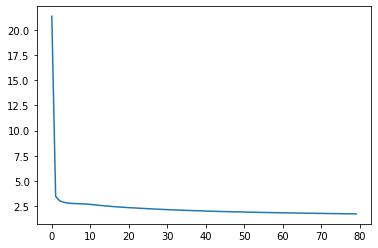

In [31]:
from IPython.display import display, clear_output

if DO_TRAIN:
    epochs = 80
    save_step = 20

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) 

    model = model.train()
    losses = []
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        losses_step = []
        for i, batchs in enumerate(training_loader):
            for j, db in enumerate(batchs):
                optimizer.zero_grad()

                # Get Data
                src_seq = db["text"].long().to(device)
                mel_target = db["mel_target"].float().to(device)
                length_target = db["duration"].int().to(device)
                mel_pos = db["mel_pos"].long().to(device)
                src_pos = db["src_pos"].long().to(device)
                mel_max_length = db["mel_max_len"]

                mel_output, duration_predictor_output = model(src_seq, src_pos, mel_pos, mel_max_length, length_target)

                mse_loss = nn.MSELoss()
                l1_loss = nn.L1Loss()

                mel_target.requires_grad = False
                mel_loss = mse_loss(mel_output, mel_target.transpose(1, 2))
                length_target.requires_grad = False
                duration_predictor_loss = l1_loss(duration_predictor_output,
                                                  length_target.float())
                total_loss = mel_loss + duration_predictor_loss

                # Logger
                losses_step.append(total_loss.item())

                # Backward
                total_loss.backward()

                # Clipping gradients to avoid gradient explosion
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                scheduled_optimizer.step()
        losses.append(np.mean(losses_step))
        ax.cla()
        ax.plot(np.arange(0, epoch+1), losses)
        display(progress_bar.container)
        display(fig)    
        clear_output(wait = True)

        if ((epoch+1)%save_step) == 0:
            torch.save(model.state_dict(), path)

In [26]:
if DO_EVAL:
    model.load_state_dict(torch.load(path))

In [27]:
torch.cuda.empty_cache()

In [28]:
for i, batch in enumerate(training_loader):
    src_seq = batch[0]["text"].long().to(device)
    mel_target = batch[0]["mel_target"].float().to(device)
    break

In [29]:
model.eval()
mel_output = model(src_seq, src_pos=None)

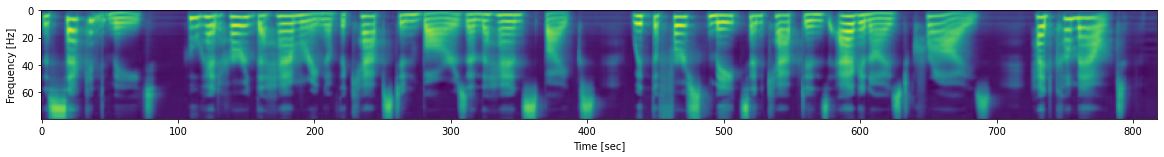

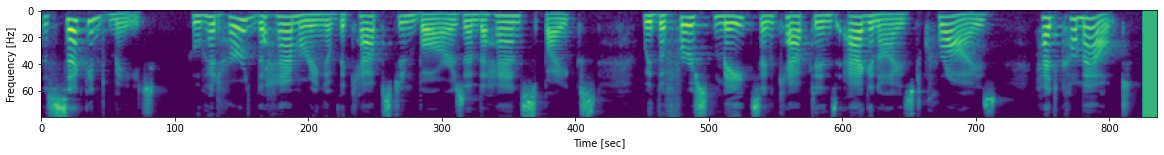

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(mel_output[0].cpu().detach().numpy().T)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(mel_target[0].cpu().detach().numpy())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

In [32]:
torch.cuda.empty_cache()

In [33]:
text_eng = "Last homework. We are in a deep trouble. No sleep tonight."
text_rus = "Синтезаторы речи Text to Speech (TTS) — специальные программы, позволяющие формировать речевой сигнал (речь, голос) по печатному тексту."

sequences_e, _ = utils.prepare_input_sequence([text_eng]*2)
sequences_r, _ = utils.prepare_input_sequence([text_rus]*2)

sys:1: UserWarning: Unexpected character —: please revise your text cleaning rules.
sys:1: UserWarning: Unexpected character —: please revise your text cleaning rules.


In [34]:
with torch.no_grad():
    mel_output = model(sequences_r, src_pos=None)
    audio_rus = waveglow.infer(mel_output[:1, :, :].transpose(1, 2))

    mel_output = model(sequences_e, src_pos=None)
    audio_eng = waveglow.infer(mel_output[:1, :, :].transpose(1, 2))

In [35]:
audio_numpy = audio_eng.data.cpu().numpy()
Audio(audio_numpy, rate=sample_rate)

In [36]:
audio_numpy = audio_rus.data.cpu().numpy()
Audio(audio_numpy, rate=sample_rate)

# Using Torchhub and Trained Tacatron2

![picture](https://drive.google.com/uc?export=view&id=1xVKI31-6BX__fY9a_kjie08DCuWFZs0d)

source: https://arxiv.org/pdf/1712.05884.pdf

In [2]:
import torch

In [ ]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

In [46]:
text = "Last homework. We are in a deep trouble. No sleep tonight."

In [47]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [48]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    print(mel.shape)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

torch.Size([1, 80, 441])


In [49]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)